In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
! pip install "transformers" "pytorch-lightning"

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 582 kB 47.2 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 6.6 MB 33.7 MB/s 
     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 408 kB 45.0 MB/s 
     |████████████████████████████████| 136 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 47.2 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 61.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import json
import pandas as pd
import numpy as np
import time
import heapq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 
from yellowbrick.cluster import KElbowVisualizer

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
likes_path = "/content/drive/MyDrive/Tesi/easytour-likes-2022-03MAR-21.json"
schede_path = "/content/drive/MyDrive/Tesi/easytour-schede-2022-03MAR-21.json"
data_path = "/content/drive/MyDrive/Tesi/data.csv"

In [7]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path, encoding_errors='ignore')  

In [8]:
categories = ["aria aperta", "cultura", "food", "sport", "tempo libero", "viaggi"]

In [9]:
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_likes_ids = df_likes[["id", "userId"]]

In [10]:
df_schede

,id,userId,userName,documentType,title,description,locations,feature,duration,imageId,...,categories,media,shareType,status,lastUpdate,versionHistory,viewCounter,device,timestamp,errorCodes
0,62355f98272ae5672fbc3ac7,632,Forestlife Adventure,experience,Spiagge selvagge a Phuket 🇹🇭,"Phuket, il paradiso per gli amanti del sole, d...",[{'photoReference': 'Aap_uEDKOn5xZw8whBhgYdkkO...,[],0.0,62355c31272ae5672fbc3a9d,...,[Viaggi],{'photos': [{'fileId': '62355c31272ae5672fbc3a...,SHARED,PUBLISHED,2022-03-19T04:44:08.475Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",2.0,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaT,NaN
1,620abb33ff8ae67f37cafe3c,442,lollo_cata,experience,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,[{'photoReference': 'Aap_uECP3iO80ReEkce8JB_2s...,[],3600000.0,620ab9e4ff8ae67f37cafe30,...,[Viaggi],{'photos': [{'fileId': '620ab9e4ff8ae67f37cafe...,SHARED,PUBLISHED,2022-02-14T20:27:31.966Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",413.0,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaT,NaN
2,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,[],3600000.0,620aa384ff8ae67f37cafaf9,...,[Viaggi],{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",414.0,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaT,NaN
3,62349ff2272ae5672fbc3135,632,Forestlife Adventure,experience,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,[{'photoReference': 'Aap_uEA4LhCYzVzbaHBUWsYoz...,[],0.0,62349c0c272ae5672fbc30d6,...,[Viaggi],{'photos': [{'fileId': '62349c0c272ae5672fbc30...,SHARED,PUBLISHED,2022-03-19T04:48:48.248Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",4.0,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaT,NaN
4,6234aa65272ae5672fbc34c2,632,Forestlife Adventure,experience,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",[{'photoReference': 'Aap_uEDR-tkPt3POWYoKoWcHy...,[],0.0,6234a758272ae5672fbc32aa,...,[Viaggi],{'photos': [{'fileId': '6234a758272ae5672fbc32...,SHARED,PUBLISHED,2022-03-19T04:04:25.742Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",4.0,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,61f57f62306802033034ceed,536,Dierre,experience,Avventura in Ecuador - le cascate di Baños,Ripartiamo dopo la nostra esperienza in Amazzo...,[{'photoReference': 'Aap_uEAfFF1aYaMIf6humUc5A...,[],259200000.0,61f57ec1306802033034ce0b,...,[Viaggi],{'photos': [{'fileId': '61f57ec1306802033034ce...,SHARED,PUBLISHED,2022-01-29T17:54:42.343Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",42.0,"{'deviceModel': 'OnePlus ONEPLUS A5000', 'devi...",NaT,NaN
4352,61f668fa306802033034d239,536,Dierre,experience,Avventura in Ecuador - el Volcán Chimborazo,E così ci lasciamo alle spalle anche la splend...,[{'photoReference': 'Aap_uEAqrgQG8owp47AkkEkco...,[],57600000.0,61f66823306802033034d1dd,...,[Viaggi],{'photos': [{'fileId': '61f66823306802033034d1...,SHARED,PUBLISHED,2022-01-30T10:31:22.188Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",35.0,"{'deviceModel': 'OnePlus ONEPLUS A5000', 'devi...",NaT,NaN
4353,620bbf26b1675d6cc11232f8,431,iviaggidimanuel,experience,"Lomas de Paraíso VMT, polmone verde","La chiamano ""ciudad gris"" Lima. Per circa quat...",[{'photoReference': 'Aap_uEAxRGACqtjJN55mSh-Md...,[],9000000.0,620bbe17b1675d6cc11232aa,...,[Viaggi],{'photos': [{'fileId': '620bbe17b1675d6cc11232...,SHARED,PUBLISHED,2022-02-15T14:56:38.352Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",37.0,"{'deviceModel': 'HUAWEI SNE-LX1', 'deviceOS': ...",NaT,NaN
4354,61f3c6add91e9928f6e0922a,431,iviaggidimanuel,experience,Il meglio di Lima,È quasi impossibile trovare un angolo del Perù.

In [11]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,['spiaggia'],"['paradiso', 'amant', 'sole', 'mare', 'sole', ...",0.0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,2.0,0,0,0,0,0,1,0.0,9
1,620abb33ff8ae67f37cafe3c,442,[],"['spiaggia', 'isola', 'spiaggia', 'mare', 'ter...",3600000.0,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,0,413.0,0,0,0,0,0,1,60.0,41
2,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'sconsi...",3600000.0,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,414.0,0,0,0,0,0,1,60.0,41
3,62349ff2272ae5672fbc3135,632,['big'],"['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
4,6234aa65272ae5672fbc34c2,632,"['wat', 'tempio']","['spiaggia', 'pena', 'tempio', 'big', 'tempio'...",0.0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,61f57f62306802033034ceed,536,"['avventura', 'cascata']","['esperienza', 'step', 'contatto', 'realtà', '...",259200000.0,2022-01-29T17:54:42.761Z,2022-01-29T17:54:42.000+00:00,0,42.0,0,0,0,0,0,1,4320.0,57
4352,61f668fa306802033034d239,536,['avventura'],"['spalla', 'esperienza', 'lascito', 'vista', '...",57600000.0,2022-01-30T10:31:22.977Z,2022-01-30T10:31:22.000+00:00,0,35.0,0,0,0,0,0,1,960.0,57
4353,620bbf26b1675d6cc11232f8,431,"['loma', 'polmon']","['mese', 'sole', 'capital', 'nuvola', 'nebbia'...",9000000.0,2022-02-15T14:56:39.554Z,2022-02-15T14:56:38.000+00:00,1,37.0,0,0,0,0,0,1,150.0,41
4354,61f3c6add91e9928f6e0922a,431,['lima'],"['angolo', 'turista', 'calor', 'gent', 'bellez...",172800000.0,2022-02-01T16:57:01.557Z,2022-01-28T10:34:21.000+00:00,1,51.0,0,0,0,0,0,1,2880.0,59


# Tf-Idf

In [12]:
def compute_tfidf_on_whole_dataset(data):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=5,
                                          max_df=0.10)
  # description and title are put together
  text = data['description'] + data['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [13]:
df_tfidf = compute_tfidf_on_whole_dataset(data)
df_tfidf

,10,39,abat,abbacchio,abbandono,abbazia,abbellimento,abbeveratoio,abbigliamento,abbinamento,...,ziplin,zoccolo,zodiaco,zolfo,zoo,zoologia,zucca,zucchero,zucchin,zuppa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def compute_tfidf_single_category(data, category:str):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=5,
                                          max_df=0.10)
  # description and title are put together
  data_category = data[data[category]!=0]
  text = data_category['description'] + data_category['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data_category.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [15]:
tfidf_dict = dict()
for c in categories:
  tfidf_dict[c] = compute_tfidf_single_category(data, category=c)

In [16]:
tfidf_dict["food"]

,abbacchio,abbinamento,abbondanza,abitant,abitudin,accento,accesso,accessorio,acciuga,accoglienza,...,yogurt,zabaion,zafferano,zenzero,zeppol,zia,zucca,zucchero,zucchin,zuppa
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312145,0.0,0.189978,0.0,0.0,0.0,0.0,0.129271,0.0,0.000000
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.439869,0.0,0.178476,0.0,0.0,0.0,0.0,0.121444,0.0,0.000000
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.226681,0.0,0.000000
4263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.273905


# Embeddings

## Word2Vec

## Transformers

For each description, compute the average of the embeddings of each sentence. 

In [17]:
from math import ceil
from tqdm import tqdm

In [18]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [19]:
class MyTransformer():
    def __init__(
            self,
            pretrained_model_name_or_path: str = "dbmdz/bert-base-italian-cased",
            device: str = 'cpu'
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        self.model = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.model.to(device)
        print("Device used: {}".format(self.model.device))

    def add_special_tokens(self, tokens_ids):
      # add CLS (token_id is 101) and SEP (token_id is 102)
      ids = [101] + tokens_ids + [102]
      # add padding (token_id is 0)
      padding_length = 512-len(ids)
      for i in range(padding_length):
        ids += [0]
      #print("\n padding_length: {} - len(tokens_ids): {}\nTokens_ids: {}".format(padding_length, len(ids), ids))
      return ids

    def compute_embedding(self, tokens_ids):
      self.model.eval()
      with torch.no_grad():
        if(len(tokens_ids) <= 510):
          tokens_ids = self.add_special_tokens(tokens_ids)
          context_embeddings = self.model(torch.tensor(tokens_ids)[None,:].to(device))[0]
        else:
          k = ceil(len(tokens_ids) / 510.0)
          chunks = np.array_split(tokens_ids, k)
          for i in range(len(chunks)):
            chunks[i] = self.add_special_tokens(chunks[i].tolist())
          #first_chunk = self.add_special_tokens(chunks[0])
          chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
          context_embeddings_list = self.model(chunks_tensor)[0].to(device)
          for i in range(1, len(chunks)):
            chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
            context_embeddings_list = torch.cat((context_embeddings_list, self.model(chunks_tensor)[0]), 1)
          dim = context_embeddings_list.shape[-1]
          context_embeddings = context_embeddings_list.to(device)
        #compute the average of the vectors
        avg_embeddings = torch.mean(context_embeddings,1)[0]
      return avg_embeddings

    def encode(self, data, docs, categories:list):
        start = time.time()
        encodings_dict = dict()
        for c in categories:
          encodings = []
          data_category_index = data[data[c]!=0].index
          filtered_docs = docs.filter(data_category_index, axis=0)
          for _, d in tqdm(enumerate(filtered_docs)): 
            if not d: #df_schede has null descriptions
              print("In category {} there is an empty scheda".format(c))
              encodings.append(torch.zeros(768))
              continue
            t = self.tokenizer.tokenize(d)
            tokens_ids = self.tokenizer.convert_tokens_to_ids(t)
            encodings.append(self.compute_embedding(tokens_ids))
          encodings_dict[c] = encodings #pd.Dataframe?
        print("\nTime needed to encode {} documents: {}s".format(len(docs), time.time()-start))
        return encodings_dict

    def text_tokens_length(self, docs):
      res = 0
      N = len(docs) #number of docs
      max = 0
      longer_than_510 = 0
      for idx, d in tqdm(enumerate(docs)): 
        if not d: #df_schede has one null description
          N -= 1
          continue
        t = self.tokenizer.tokenize(d)
        length = len(t)
        res += length
        if length>max:
          max=length
        if length > 510:
          longer_than_510 += 1
      print("\nAverage number of tokens is {}\nMax number of tokens is {}\nNumber of sequences than have more than 510 tokens is {}".format(res/N, max, longer_than_510))

In [20]:
model = MyTransformer(device=device)
#model.text_tokens_length(df_schede.description)
embeddings = model.encode(data, df_schede.description, categories)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device used: cuda:0


1it [00:00,  5.23it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
671it [00:28, 23.61it/s]
757it [00:29, 25.72it/s]
1092it [00:44, 24.78it/s]
5it [00:00, 40.62it/s]

In category sport there is an empty scheda


311it [00:12, 24.36it/s]
29it [00:01, 29.56it/s]

In category tempo libero there is an empty scheda


532it [00:19, 26.74it/s]
778it [00:36, 21.31it/s]


Time needed to encode 4356 documents: 171.1752371788025s


In [21]:
embeddings_path = "/content/drive/MyDrive/Tesi/embeddings_"
for c in categories:
  category_path = embeddings_path + c + ".pt"
  torch.save(embeddings[c], category_path)

In [22]:
embeddings_from_file = {}
for c in categories:
  category_path = embeddings_path + c + ".pt"
  embeddings_from_file[c] = torch.load(category_path)

# Recommender systems

In [137]:
df_likes_ids.userId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
3        True
5        True
6       False
        ...  
1338    False
1425     True
1458    False
1459    False
1468    False
Name: userId, Length: 116, dtype: bool

In [138]:
#list of user
#some ids in likes are not in posts -> some users liked posts but not posted one
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates() 
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
#list of posts and users that liked that post
posts_with_likes = df_likes_ids.groupby("id").userId.apply(list)
#list of users and posts they liked
users_with_likes = df_likes_ids.groupby("userId").id.apply(list)
#users that have not posted anything
users_without_posts = users[~users.isin(users_posts.index)].values
#users that did not like any posts
users_without_likes_made = users[~users.isin(users_with_likes.index)].values
#posts that did not receive any likes
posts_without_likes = posts[~posts.isin(posts_with_likes.index)].values

print("Number of users: {}".format(len(users)))
print("Number of posts: {}".format(len(posts)))
print("Number of users that posted something: {}".format(len(users_posts)))
print("Number of posts that received likes: {}".format(len(posts_with_likes)))
print("Number of likes: {}".format(len(posts_with_likes.values))) #check this again
print("Number of users that liked posts: {}".format(len(users_with_likes)))
print("Number of users that not posted anything: {}".format(len(users_without_posts)))
print("Number of users that not liked anything: {}".format(len(users_without_likes_made)))
print("Number of posts that not received likes: {}".format(len(posts_without_likes)))

Number of users: 179
Number of posts: 4356
Number of users that posted something: 142
Number of posts that received likes: 1124
Number of likes: 1124
Number of users that liked posts: 116
Number of users that not posted anything: 37
Number of users that not liked anything: 63
Number of posts that not received likes: 3232


In [139]:
data_with_ids = data.drop(columns=["datePublishing", "creationDate", "duration", "description", "title", "counterUseful", "viewCounter"])

In [140]:
#"duration_min", "days"
X = data.drop(columns=["id", "userId", "description", "title", "datePublishing", "creationDate", "duration", "counterUseful", "viewCounter"])

In [141]:
X

,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,0,0,0,0,0,1,0.0,9
1,0,0,0,0,0,1,60.0,41
2,0,0,0,0,0,1,60.0,41
3,0,0,0,0,0,1,0.0,10
4,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...
4351,0,0,0,0,0,1,4320.0,57
4352,0,0,0,0,0,1,960.0,57
4353,0,0,0,0,0,1,150.0,41
4354,0,0,0,0,0,1,2880.0,59


## **Method \#1**

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [142]:
cosine_sim = cosine_similarity(df_tfidf, df_tfidf)

In [143]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [144]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
92    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [145]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 61f6ce0b306802033034e3e7
Title: Le spiagge più belle della Sardegna
Description: La Sardegna è una regione ricca di spiagge meravigliose e mare dal colore cristallino, cercheremo di aiutarvi a trovare le spiagge più belle e quelle che secondo noi non potete assolutamente perdervi se fate un viaggio in questa regione fantastica!

📌Berchida
Berchida è una delle spiagge più lunghe e spaziosi della Sardegna. La Spiaggia è posizionata poco sopra il Golfo di Orosei ed è quasi tutta di sabbia finissima, inoltre, riesce a sorprenderti per i colori della sua acqua, davvero cristallina. La grandezza della spiaggia gioca a favore anche per la possibilità di avere un po’ di privacy e relax.

📌Spiaggia di S’archittu
Questa spiaggia è situata nella parte ovest della Sardegna poco sopra Oristano. La spiaggia in sé non è molto grande quindi vi consigliamo di arrivare presto per trovare posto. La particolarità è la presenza di un arco, appunto Archittu, formato dalla scogliera che rac

## **Method \#2**

**Method #2:** Similarity of users is given by the number of common clusters for the posts they made or liked 

### K-means

In [146]:
#Plot data using SVD
def plot_with_SVD(data:pd.DataFrame, categories:list, description_dict:dict):
  svd_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    svd = svd.fit_transform(data_with_encodings)
    svd_dict[c] = svd
    plt.scatter(svd[:,0], svd[:,1])
    plt.title("Category: " + c)
    plt.show()
  return svd_dict

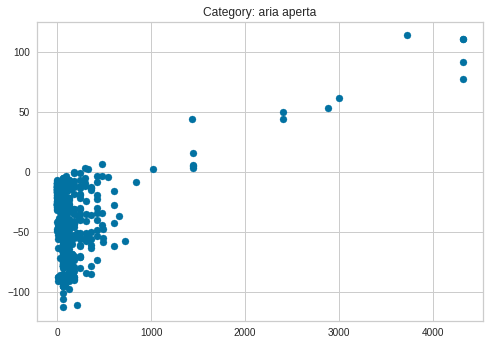

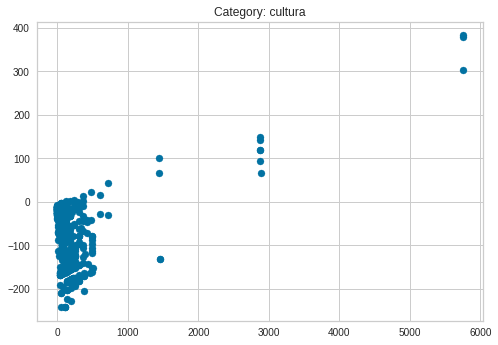

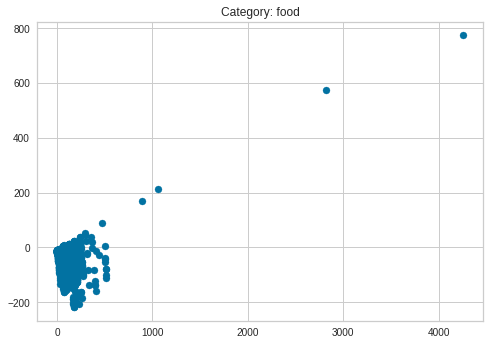

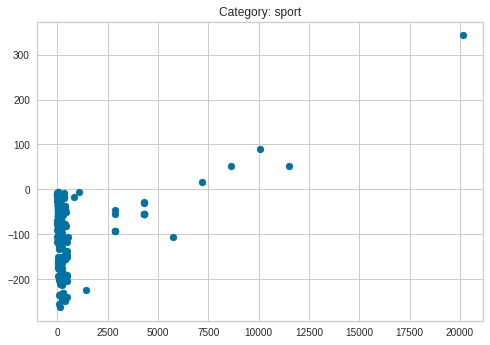

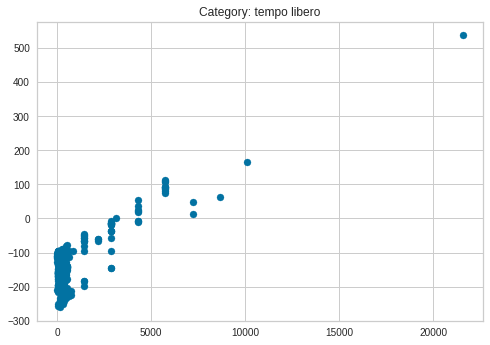

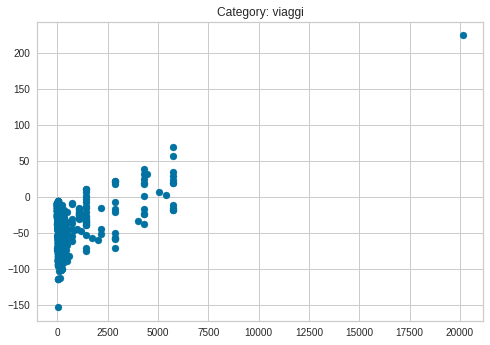

In [147]:
svd_dict_tfidf = plot_with_SVD(X, categories, tfidf_dict)

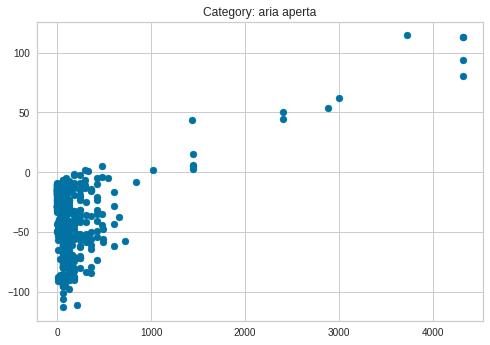

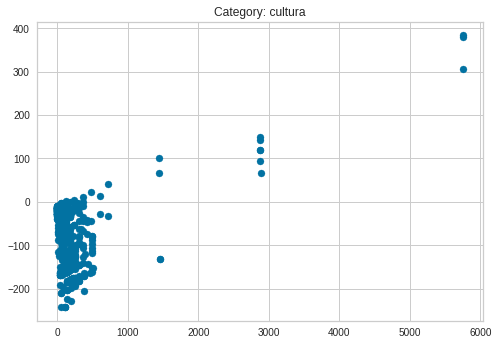

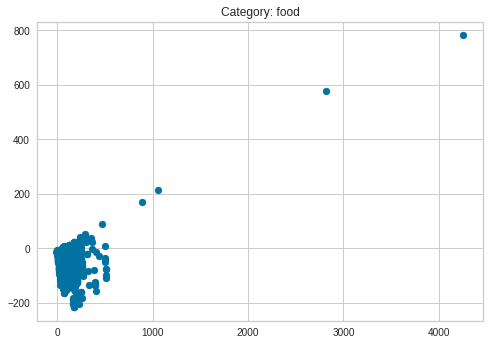

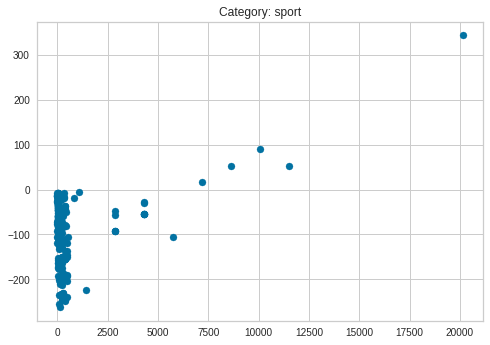

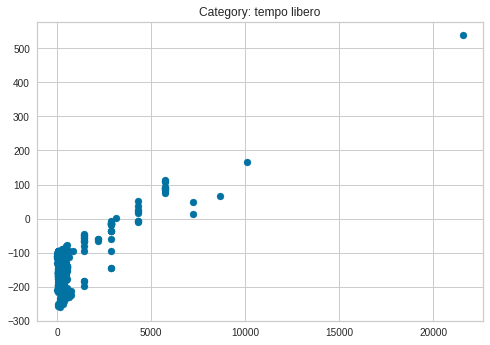

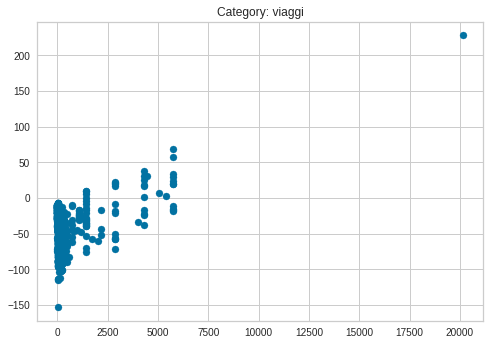

In [148]:
svd_dict_embeddings = plot_with_SVD(X, categories, embeddings)

In [149]:
#Plot results
def plotKMeans(label:np.ndarray, df:pd.DataFrame, category:str):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters for {}'.format(len(u_labels), category))
  plt.legend()
  plt.show()

In [150]:
def kmeans_tests(data:pd.DataFrame, category:str, svd_dict:dict, clusters_number:int=10, steps:int=1):
  inertia = []
  times = dict() #{k:time_needed}
  K = range(2,clusters_number,steps) 
  for k in K:
      #Fit 
      start = time.time()
      kmeanModel = KMeans(n_clusters=k)
      kmeans = kmeanModel.fit(data)
      time_needed = time.time() - start
      times[k] = time_needed
      #Elbow
      inertia.append(kmeanModel.inertia_)
      #Clusters
      label = kmeans.predict(data)
      plotKMeans(label, svd_dict[category], category)
  return inertia, times, K

In [151]:
def elbow_and_statistics(inertia:list, times:dict, K:list):
  #Elbow
  plt.figure(figsize=(10,3))
  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()
  print("\n")
  #Inertia
  for k,value in zip(K, inertia):
    print("Inertia for {} clusters is: {}".format(k,value))
  print("\n")
  #Times needed
  for k,v in times.items():
    print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

In [152]:
def elbow_visualizer(data:pd.DataFrame, k:int):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=k)
  visualizer.fit(data)        
  visualizer.show() 

In [153]:
def kmeans_computation(data:pd.DataFrame, description_dict:dict, categories:list, svd:dict, k:int, visualizer:bool=False):
  assert type(categories)==list, "Expected list as input not {}".format(type(categories))
  for c in categories:
    print("Category: {}".format(c))
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    if visualizer:
      #kmeans
      inertia, times, K = kmeans_tests(data_with_encodings, c, svd, k)
      # Elbow and inertia
      elbow_and_statistics(inertia, times, K)
    else:
      elbow_visualizer(data_with_encodings, k)  

Category: aria aperta


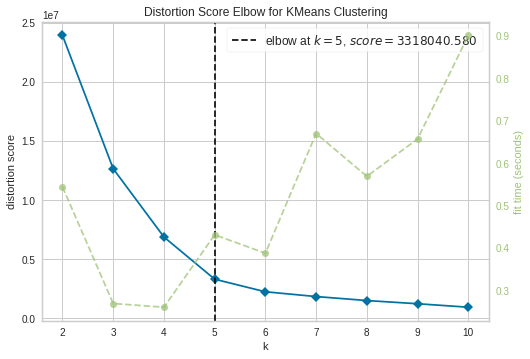

Category: cultura


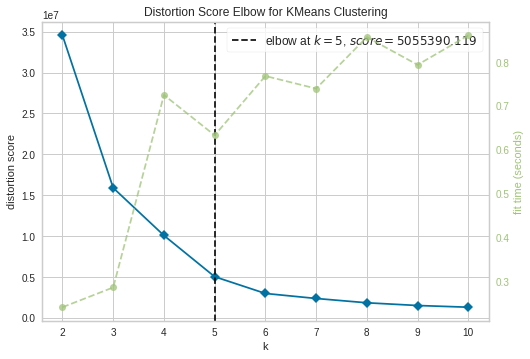

Category: food


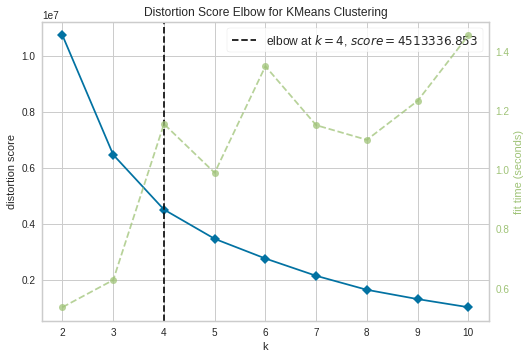

Category: sport


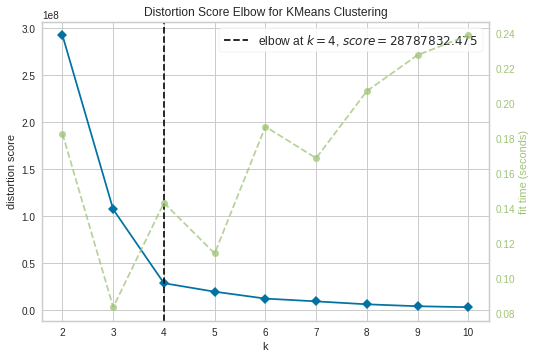

Category: tempo libero


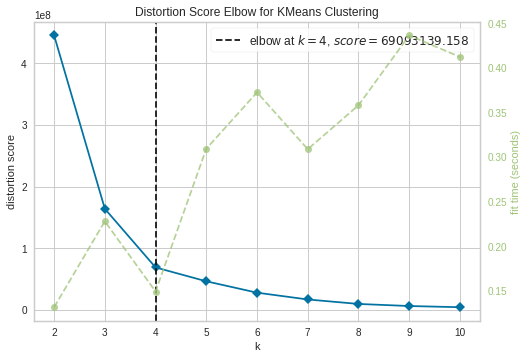

Category: viaggi


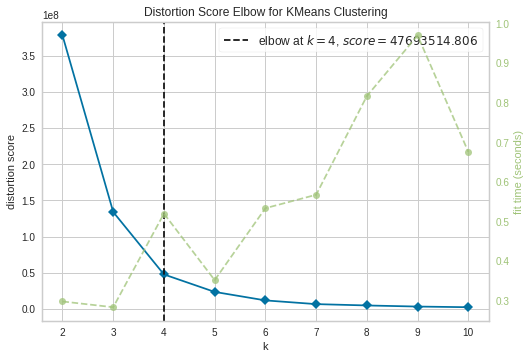

In [154]:
#kmeans_computation(["food"])
kmeans_computation(X, tfidf_dict, categories, svd_dict_tfidf, 10)

Category: aria aperta


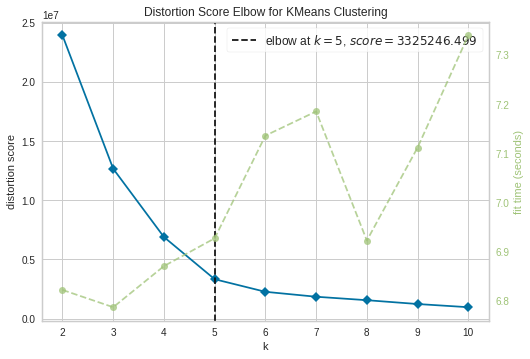

Category: cultura


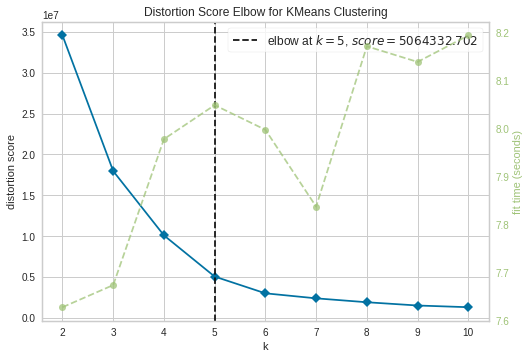

Category: food


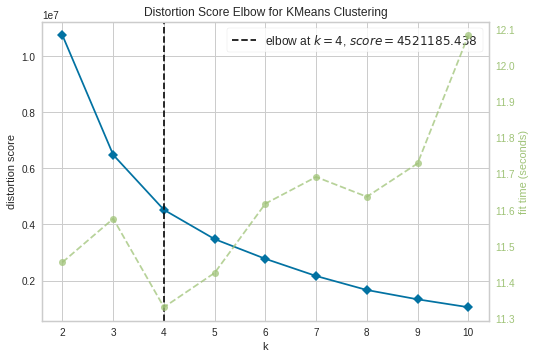

Category: sport


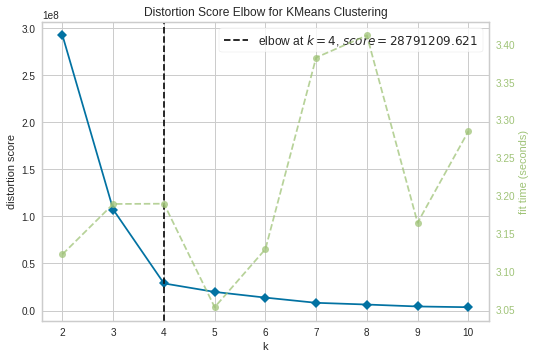

Category: tempo libero


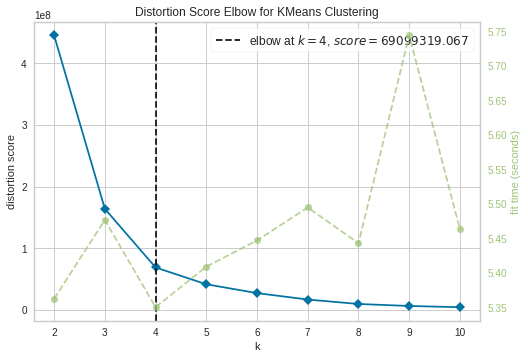

Category: viaggi


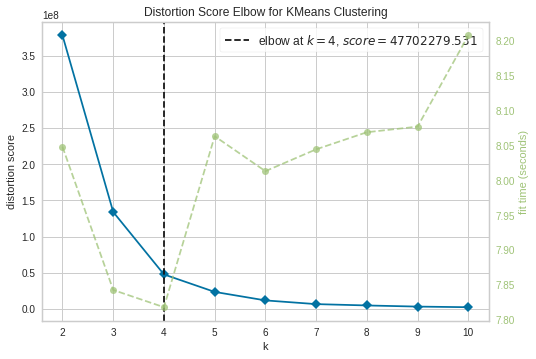

In [155]:
#kmeans_computation(["food"])
kmeans_computation(X, embeddings, categories, svd_dict_embeddings, 10)

### DBSCAN

In [156]:
from sklearn.cluster import DBSCAN
from collections import Counter

In [157]:
def plot_dbscan(data:pd.DataFrame, labels:np.ndarray, core_samples_mask:np.ndarray, n_clusters_:int):  
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      data_array = data.to_numpy()
      class_member_mask = labels == k
      xy = data_array[class_member_mask & core_samples_mask]
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=14,
      )

      xy = data_array[class_member_mask & ~core_samples_mask]
      plt.plot(
          xy[:, 0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=6,
      )

  plt.title("Estimated number of clusters: %d" % n_clusters_)
  plt.show()

In [158]:
def DBSCAN_categories(data:pd.DataFrame, categories:list, description_dict:dict, plot:bool=False):
  dbscan_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    clustering = DBSCAN(eps=10, min_samples=10).fit(data_with_encodings)
    dbscan_dict[c] = clustering
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    counter = Counter(labels)
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    print("Category '{}' has {} clusters and {} noisy points\nDistribution of the samples in the clusters: {}\n".format(c, n_clusters_, n_noise_, counter))
    if plot:
      core_samples_mask = np.zeros_like(labels, dtype=bool)
      core_samples_mask[clustering.core_sample_indices_] = True
      plot_dbscan(data_with_encodings, labels, core_samples_mask, n_clusters_)
  return dbscan_dict

Category 'aria aperta' has 5 clusters and 183 noisy points
Distribution of the samples in the clusters: {1: 374, -1: 183, 0: 64, 3: 20, 2: 18, 4: 12}



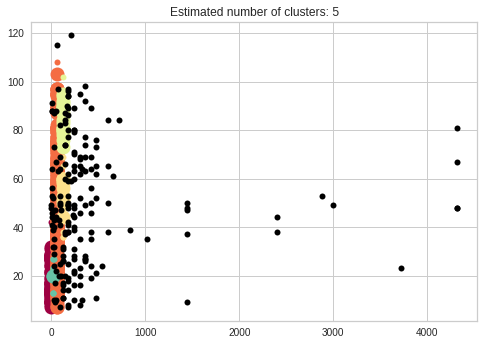

Category 'cultura' has 8 clusters and 244 noisy points
Distribution of the samples in the clusters: {1: 295, -1: 244, 0: 64, 2: 57, 3: 25, 6: 24, 7: 19, 4: 15, 5: 14}



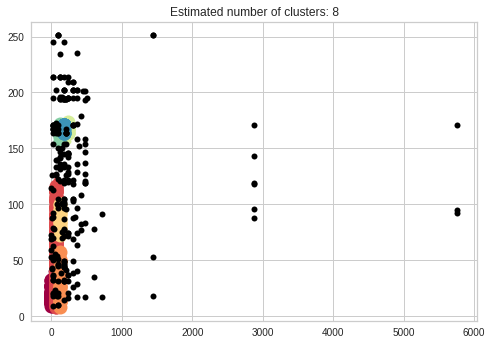

Category 'food' has 7 clusters and 195 noisy points
Distribution of the samples in the clusters: {1: 510, -1: 195, 2: 174, 0: 162, 6: 18, 4: 13, 5: 11, 3: 9}



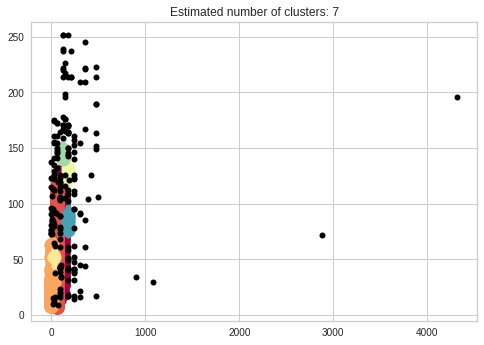

Category 'sport' has 3 clusters and 182 noisy points
Distribution of the samples in the clusters: {-1: 182, 2: 99, 0: 16, 1: 14}



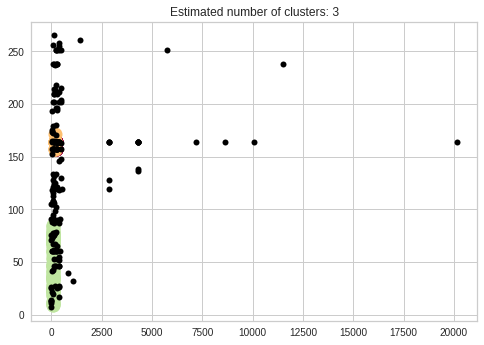

Category 'tempo libero' has 11 clusters and 281 noisy points
Distribution of the samples in the clusters: {-1: 281, 2: 62, 0: 34, 4: 26, 8: 23, 5: 18, 9: 17, 1: 15, 6: 15, 10: 14, 7: 14, 3: 13}



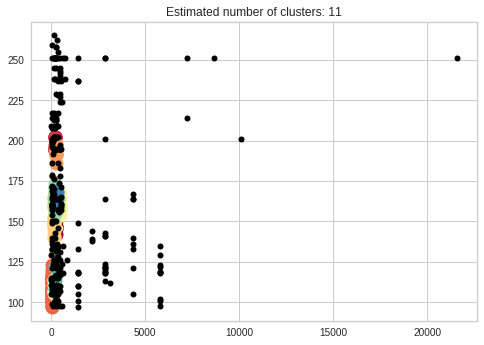

Category 'viaggi' has 5 clusters and 191 noisy points
Distribution of the samples in the clusters: {1: 466, -1: 191, 0: 81, 2: 16, 4: 14, 3: 10}



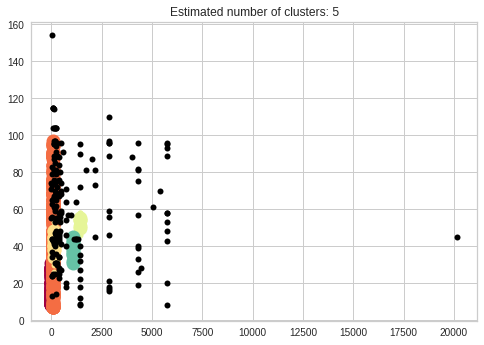

In [159]:
dbscan_tfidf = DBSCAN_categories(X, categories, tfidf_dict, plot=True)

Category 'aria aperta' has 5 clusters and 190 noisy points
Distribution of the samples in the clusters: {1: 374, -1: 190, 0: 63, 2: 22, 4: 13, 3: 9}



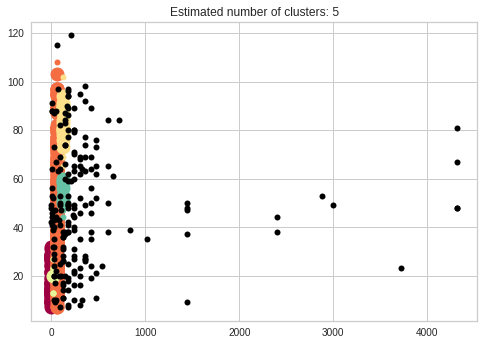

Category 'cultura' has 8 clusters and 244 noisy points
Distribution of the samples in the clusters: {1: 295, -1: 244, 0: 64, 2: 57, 3: 25, 6: 24, 7: 19, 4: 15, 5: 14}



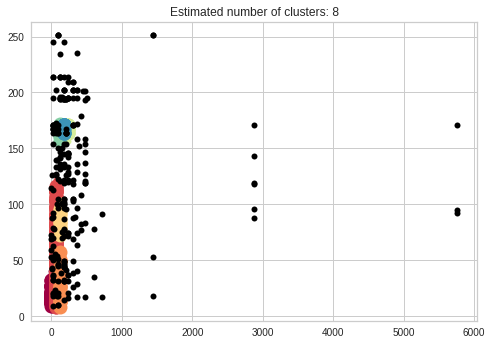

Category 'food' has 6 clusters and 207 noisy points
Distribution of the samples in the clusters: {1: 509, -1: 207, 2: 174, 0: 162, 5: 18, 3: 11, 4: 11}



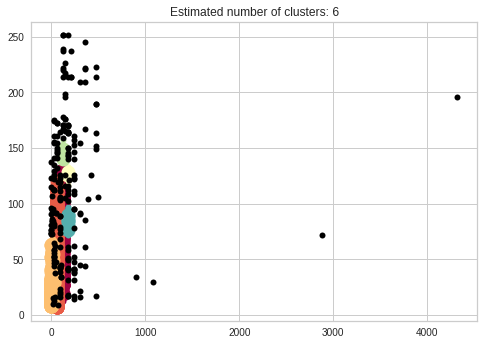

Category 'sport' has 3 clusters and 182 noisy points
Distribution of the samples in the clusters: {-1: 182, 2: 99, 0: 16, 1: 14}



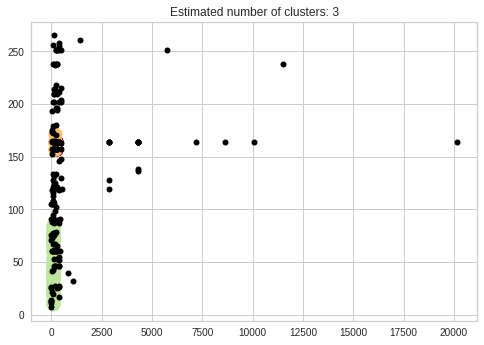

Category 'tempo libero' has 11 clusters and 294 noisy points
Distribution of the samples in the clusters: {-1: 294, 2: 61, 0: 34, 4: 26, 8: 23, 5: 18, 1: 15, 10: 14, 7: 14, 3: 13, 9: 10, 6: 10}



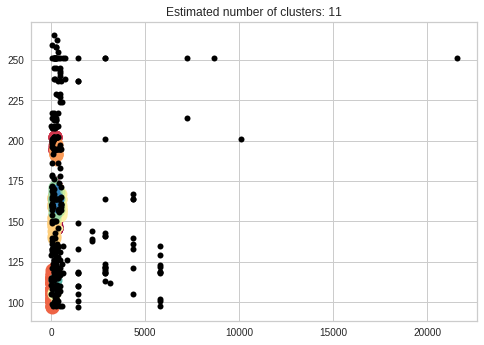

Category 'viaggi' has 5 clusters and 192 noisy points
Distribution of the samples in the clusters: {1: 466, -1: 192, 0: 81, 2: 15, 4: 14, 3: 10}



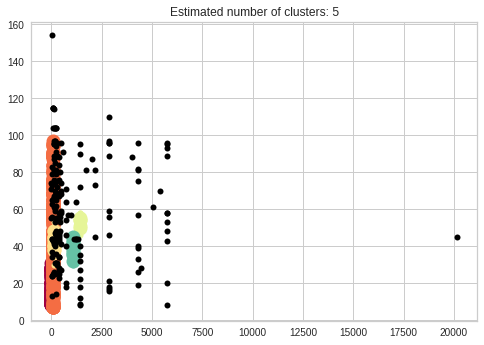

In [160]:
dbscan_embeddings = DBSCAN_categories(X, categories, embeddings, plot=True)

### GMM

In [161]:
from sklearn.mixture import GaussianMixture

def GMM_categories(data:pd.DataFrame, categories:list, tfidf_dict:dict, plot:bool=False):
  gmm_dict = dict()
  for c in categories:
    tfidf = tfidf_dict[c]
    data_with_tfidf = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_with_tfidf.drop(columns=categories, inplace=True)
    gm = GaussianMixture(n_components=5, random_state=0).fit(data_with_tfidf)
    gmm_dict[c] = gm
    labels = gm.means_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    counter = Counter(labels)
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
    print("Category '{}' has {} clusters and {} noisy points\nDistribution of the samples in the clusters: {}\n".format(c, n_clusters_, n_noise_, counter))
    # if plot:
    #   core_samples_mask = np.zeros_like(labels, dtype=bool)
    #   core_samples_mask[clustering.core_sample_indices_] = True
    #   plot_dbscan(data_with_tfidf, labels, core_samples_mask, n_clusters_)
  return gmm_dict

In [162]:
#GMM_categories(X, categories, tfidf_dict, plot=True)

### RS

In [199]:
optimal_number_clusters = {"aria aperta":4, "cultura":4, "food":4, "sport":4, "tempo libero":4, "viaggi":4}
#optimal_number_clusters = {"aria aperta":7, "cultura":7, "food":7, "sport":7, "tempo libero":7, "viaggi":7}
#optimal_number_clusters = {"aria aperta":10, "cultura":10, "food":10, "sport":10, "tempo libero":10, "viaggi":10}

In [200]:
# Return list of ranking for clusters ordered in ascending manner by number of posts
# the list has in i-th position the ranking of the i-th cluster 
def rank_clusters_in_categories(counts:pd.DataFrame, 
                                category:str):
  counts.sort_values(inplace=True)
  ordered_clusters = [x[0] for x in counts.index]
  ranking = [0 for x in ordered_clusters]
  for idx, r in enumerate(ordered_clusters):
    ranking[r] = idx + 1
  return ranking

# Compute the clusters for each category
def compute_clusters(data:pd.DataFrame, optimal_number_clusters:dict, description_dict:dict):
  kmeans_dict = dict()
  ranking_clusters_per_category = dict()
  for k,v in optimal_number_clusters.items():
    kmeanModel = KMeans(n_clusters=v)
    print("Category '{}' has {} clusters".format(k,v))
    data_category = data[data[k]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[k], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)

    kmeans = kmeanModel.fit(data_with_encodings.values)
    kmeans_dict[k] = kmeans
    #print number of posts in each cluster
    labels = kmeans.labels_
    count_elem_per_cluster = pd.DataFrame(labels).value_counts()
    ranking_clusters_per_category[k] = rank_clusters_in_categories(count_elem_per_cluster, k)
    print(count_elem_per_cluster)
    print()
  #print(ranking_clusters_per_category)
  return kmeans_dict, ranking_clusters_per_category

In [201]:
kmeans_tfidf_dict, ranking_clusters_per_category_tfidf = compute_clusters(X, optimal_number_clusters, tfidf_dict)

Category 'aria aperta' has 4 clusters
1      7
3      8
0     72
2    584
dtype: int64

Category 'cultura' has 4 clusters
2      3
1      6
3     61
0    687
dtype: int64

Category 'food' has 4 clusters
1      2
2     25
0    297
3    768
dtype: int64

Category 'sport' has 4 clusters
3      1
1      4
2     13
0    293
dtype: int64

Category 'tempo libero' has 4 clusters
2      1
1     14
3     28
0    489
dtype: int64

Category 'viaggi' has 4 clusters
2      1
1     25
3     59
0    693
dtype: int64



In [202]:
print(ranking_clusters_per_category_tfidf)

{'aria aperta': [3, 1, 4, 2], 'cultura': [4, 2, 1, 3], 'food': [3, 1, 2, 4], 'sport': [4, 2, 3, 1], 'tempo libero': [4, 2, 1, 3], 'viaggi': [4, 2, 1, 3]}


In [203]:
kmeans_embeddings_dict, ranking_clusters_per_category_embeddings = compute_clusters(X, optimal_number_clusters, embeddings)

Category 'aria aperta' has 4 clusters
1      7
2      8
3     72
0    584
dtype: int64

Category 'cultura' has 4 clusters
3      3
2      6
0     61
1    687
dtype: int64

Category 'food' has 4 clusters
1      2
3     21
2    286
0    783
dtype: int64

Category 'sport' has 4 clusters
1      1
3      4
2     13
0    293
dtype: int64

Category 'tempo libero' has 4 clusters
1      1
2     14
3     28
0    489
dtype: int64

Category 'viaggi' has 4 clusters
2      1
1     25
3     59
0    693
dtype: int64



In [204]:
print(ranking_clusters_per_category_embeddings)

{'aria aperta': [4, 1, 2, 3], 'cultura': [3, 4, 2, 1], 'food': [4, 1, 3, 2], 'sport': [4, 1, 3, 2], 'tempo libero': [4, 1, 2, 3], 'viaggi': [4, 2, 1, 3]}



The distance between two user is computed in the following way: 

1.   for each category, the distance between two users is computed as the sum of the differences in numbers of posts in each cluster weighted by the importance of each cluster in the category (a cluster with less posts weights more) and by the total number of posts of the two users;
2.   the total distance is computed using the following formula: distance = $∑_{c=1}^r \frac{d[c]}{\log_2(rank(c)+1)}$, where d is a list of distances per category computed in the previous step and rank(c) is the ranking of the category c for the target user (the ranking depends on the number of posts, i.e. the first post in the ranking is the category that has the highest number of posts)

In [205]:
from itertools import groupby
import math

# Used in the heap
def get_similarity(t:tuple):
  return t[1]

# get the ranking of the categories for the target user 
# the first category is the one with more posts
# return: list of tuples (category, #posts)
def ranking_target(target_categories:dict):
  scores_clusters = [(cat, len(s)) for cat, cluster in target_categories.items() \
                     for s in cluster.values()]
  scores_categories = []
  for i, g in groupby(sorted(scores_clusters), key=lambda x: x[0]):
      scores_categories.append([i, sum(v[1] for v in g)])
  scores_categories.sort(key=lambda x: x[1], reverse=True)
  #print(scores_categories)
  return scores_categories

# retrieve the score for a certain category
def get_score_category(ranking:list, 
                       category:str):
  score = 0
  for r in ranking:
    if r[0] == category:
      score = r[1]
  return score

# retrieve ranking of a category
def get_ranking_category(ranking:list, 
                         category:str):
  for i,r in enumerate(ranking):
    if r[0] == category:
      return i+1
  #category not in ranking -> target user has not posted in such category
  return (len(ranking))

# compute the distance between two users, given a category and the ranking of the clusters for such category
def get_cluster_distance(user_clusters:dict, 
                         target_clusters:dict, 
                         ranking:list):
  distance = 0
  if not target_clusters: #target has no clusters for this category
    distance = sum([len(cluster) for cluster in user_clusters.values()])
  elif not user_clusters:
    distance = sum([len(cluster) for cluster in target_clusters.values()])
  else:
    #take all the clusters names
    target_keys_set = set(target_clusters.keys())
    user_keys_set = set(user_clusters.keys())
    keys_set = target_keys_set | user_keys_set
    #compute distance for each cluster of the category and update total distance
    for k in keys_set:
      target_clusters_k = 0
      user_clusters_k = 0
      if k in target_keys_set:
        target_clusters_k = len(target_clusters[k])
      if k in user_keys_set:
        user_clusters_k = len(user_clusters[k])
      #distance is divided by the total number of posts and the logarith of the ranking of the cluster
      distance += abs(user_clusters_k-target_clusters_k)/((user_clusters_k+target_clusters_k)*math.log2(ranking[k]+1))
  return distance

# Compute the distance between the target user and all the other users
# and return the most similar ones (the number can be specified using top) 
def distance(target_user:int, 
             partitions_users:dict,
             ranking_clusters_per_category:dict, 
             top:int=5):
  if target_user not in partitions_users:
    print("This ({}) user does not exist".format(target_user))
    return
  heap = []
  heapq.heapify(heap)
  #get the ranking of the categories for the user
  ranking = ranking_target(partitions_users[target_user])
  for user,partitions in partitions_users.items():
    if user == target_user:
      continue 
    distance = 0
    for c in categories:
      #target_category_score = get_score_category(ranking, c)
      ranking_clusters = ranking_clusters_per_category[c]
      target_category_ranking = get_ranking_category(ranking, c)
      user_category_clusters = {}
      if c in partitions:
        user_category_clusters = partitions[c]
      # check if target user has clusters for this category
      target_category_clusters = {} 
      if c in partitions_users[target_user]:
        target_category_clusters = partitions_users[target_user][c]
      #compute distance for the actual category and update total distance
      distance_category = get_cluster_distance(user_category_clusters,
                                               target_category_clusters,
                                               ranking_clusters)
      distance += distance_category / math.log2(target_category_ranking + 1)#* (len(categories)-target_category_ranking)
      #push in the heap
    heapq.heappush(heap, (user, distance))
  return heapq.nsmallest(top, heap, key=get_similarity) 

In [206]:
def print_posts_user(user:int):
  print("Posts for user {}:".format(user))
  try:
    posts = df_schede[df_schede["userId"]==user]
  except:
    print("User does not exist")
  for _, p in posts.iterrows():
    print(p.description)
    print("-"*100)

def print_info_for_user(user:int, 
                        partition:dict):
  if user not in partition:
    print("This user does not exist")
    return
  print("Info about the clusters for the posts of user {}".format(user))
  partitions_categories = partition[user]
  for category,partitions in partitions_categories.items():
    print("Clusters for category {}: {}".format(category, len(partitions)))
    for cluster,array in partitions.items():
      print("#items in cluster {} for category {}: {}".format(cluster, category, len(array)))
    print()    

#### Considering posts users wrote

In [207]:
target_id = 129

In [208]:
# Compute the distribution of the posts in the clusters for each user
# partitions = {user1: {c0:[post12, post45], c1:[post1], c2:[post5]}, user2:{c0:[], c1:[]}, etc}
def posts_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    users = data_category["userId"]
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    # add posts to the partitions
    for u,p,d in zip(users, posts_ids, data_post.iterrows()):
      user = u
      post = p
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      if user in partitions:
          #check if category c already exists for userId
          if c in partitions[user]:
            #check if cluster already exists for the category c of userId
            if cluster in partitions[user][c]:
              partitions[user][c][cluster].append(post)
            else:
              partitions[user][c][cluster] = [post]
          else:
            partitions[user][c] = dict()
            partitions[user][c][cluster] = [post]
      else:
        partitions[user] = dict()
        partitions[user][c] = dict()
        partitions[user][c][cluster] = [post]
  return partitions

In [209]:
partitions_by_user = posts_in_partition(data_with_ids,
                                        categories,
                                        kmeans_embeddings_dict,
                                        embeddings)

# partitions_by_user = posts_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_tfidf_dict,
#                                         tfidf_dict)

In [210]:
print_info_for_user(target_id, partitions_by_user)

Info about the clusters for the posts of user 129
Clusters for category cultura: 2
#items in cluster 0 for category cultura: 2
#items in cluster 1 for category cultura: 8

Clusters for category food: 3
#items in cluster 3 for category food: 2
#items in cluster 2 for category food: 14
#items in cluster 0 for category food: 5

Clusters for category sport: 1
#items in cluster 0 for category sport: 6

Clusters for category tempo libero: 3
#items in cluster 0 for category tempo libero: 11
#items in cluster 3 for category tempo libero: 1
#items in cluster 2 for category tempo libero: 1

Clusters for category viaggi: 1
#items in cluster 0 for category viaggi: 2



In [211]:
#print_posts_user(target_id)

In [212]:
best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_embeddings)
# best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_tfidf)
best_users_from_posts

[(176, 1.671871539794977),
 (268, 2.131097063552221),
 (200, 2.5009609106569477),
 (442, 2.6697623299096644),
 (314, 2.9734084590428287)]

In [213]:
for u in best_users_from_posts:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 176
Clusters for category cultura: 1
#items in cluster 1 for category cultura: 6

Clusters for category food: 2
#items in cluster 0 for category food: 5
#items in cluster 2 for category food: 1

Clusters for category sport: 1
#items in cluster 0 for category sport: 3

Clusters for category tempo libero: 3
#items in cluster 0 for category tempo libero: 9
#items in cluster 3 for category tempo libero: 2
#items in cluster 2 for category tempo libero: 2

Clusters for category viaggi: 1
#items in cluster 0 for category viaggi: 2

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 268
Clusters for category cultura: 1
#items in cluster 1 for category cultura: 13

Clusters for category food: 2
#items in cluster 2 for category food: 1
#items in cluster 0 for category food: 7

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Cluste

#### Considering the posts the users liked

In [214]:
target_id = 129

In [215]:
# Compute distribution of the likes in the clusters for each user
# partitions = {user1: {c0:[like1, like4], c1:[like6], c2:[like3]}, user2:{c0:[], c1:[]}, etc}
def likes_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    for p,d in zip(posts_ids, data_post.iterrows()):
      post = p
      try:
        users_list = posts_with_likes.at[p] #error if p is not in posts_with_likes
      except:
        # no one liked the post -> skip it
        continue
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      for user in users_list:
        if user in partitions:
            #check if category c already exists for userId
            if c in partitions[user]:
              #check if cluster already exists for the category c of userId
              if cluster in partitions[user][c]:
                partitions[user][c][cluster].append(post)
              else:
                partitions[user][c][cluster] = [post]
            else:
              partitions[user][c] = dict()
              partitions[user][c][cluster] = [post]
        else:
          partitions[user] = dict()
          partitions[user][c] = dict()
          partitions[user][c][cluster] = [post]
  return partitions

In [216]:
partitions_by_user_likes = likes_in_partition(data_with_ids,
                                        categories,
                                        kmeans_embeddings_dict,
                                        embeddings)

# partitions_by_user_likes = likes_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_tfidf_dict,
#                                         tfidf_dict)

In [217]:
print_info_for_user(target_id, partitions_by_user_likes)

Info about the clusters for the posts of user 129
Clusters for category aria aperta: 2
#items in cluster 0 for category aria aperta: 4
#items in cluster 3 for category aria aperta: 1

Clusters for category cultura: 1
#items in cluster 1 for category cultura: 5

Clusters for category food: 2
#items in cluster 0 for category food: 2
#items in cluster 2 for category food: 3

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 4
#items in cluster 3 for category tempo libero: 1

Clusters for category viaggi: 2
#items in cluster 0 for category viaggi: 4
#items in cluster 1 for category viaggi: 1



In [218]:
print_posts_user(target_id)

Posts for user 129:
A differenza di molti miei amici non ho avuto la grande fortuna di viaggiare in vita mia.
Bali è stata la mia prima meta veramente importante. Inutile dire che mi sono innamorata al primo sguardo. 
Avevo deciso di non organizzare nel dettaglio la mia meta, non comprare guide, non documentarmi troppo attraverso foto o video del luogo. Volevo l'effetto Wow e quello ho avuto. Verde ovunque, persone felici, paesaggi mozzafiato. 
In un mese sono riuscita a girarla molto tutta in motorino, tra giungla e templi, risaie e scimmiette che attraversano la strada. Bali è magica. Ti senti avvolto da un abbraccio che ti paralizza. Non vorresti mai andartene.
----------------------------------------------------------------------------------------------------
Questa estate in moltissimi amici abbiamo scelto come destinazione la FìGrecia. Ma a differenza della maggior parte di loro che hanno deciso di trascorre le vacanze sulle isole frequentate da VIP con locali esclusivi la mia sc

In [219]:
best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_embeddings)
# best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_tfidf)
best_users_from_likes

[(150, 1.019076401663011),
 (304, 1.3266745196385872),
 (429, 1.5711840574134657),
 (399, 1.6019819255275636),
 (482, 1.6241382486804739)]

In [220]:
for u in best_users_from_likes:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 150
Clusters for category aria aperta: 1
#items in cluster 0 for category aria aperta: 5

Clusters for category food: 1
#items in cluster 2 for category food: 1

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 24
#items in cluster 2 for category tempo libero: 1

Clusters for category viaggi: 1
#items in cluster 0 for category viaggi: 22

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 304
Clusters for category aria aperta: 3
#items in cluster 0 for category aria aperta: 11
#items in cluster 3 for category aria aperta: 1
#items in cluster 2 for category aria aperta: 2

Clusters for category cultura: 1
#items in cluster 1 for category cultura: 6

Clusters for category food: 2
#items in cluster 0 for category food: 14
#items in cluster 2

#### Show recommendations

In [221]:
def print_single_result(data:pd.DataFrame, 
                        recommended_user):
  assert type(recommended_user) == tuple, "Use print_results for multiple users"
  posts = data[data["userId"]==recommended_user[0]]
  print("User: {}".format(recommended_user[0]))
  for _, p in posts.iterrows():
    print("Post:")
    print(p.description)
  print("-"*100)

def print_results(data:pd.DataFrame, 
                  recommended_users):
  assert type(recommended_users)==list, "Use print_single_result for single user"
  for u in recommended_users:
    posts = data[data["userId"]==u[0]]
    print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      print("Post:")
      print(p.description)
    print("-"*100)

In [222]:
#print_single_result(df_schede, best_users_from_posts[0])

In [223]:
#print_results(df_schede, best_users_from_posts)

In [224]:
#print_single_result(df_schede, best_users_from_likes[0])

In [225]:
#print_results(df_schede, best_users_from_likes)

Choose the posts from the best users:


1.   Consider posts that most similar users liked
2.   Consider posts with more likes
3.   Consider from which cluster they come

In [226]:
# Consider posts that most similar users liked
def get_posts_similar_users_liked(data:pd.DataFrame, 
                                  users_with_likes:pd.DataFrame, 
                                  recommended_users):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  for u in recommended_users:
    try:
      posts = users_with_likes.at[u[0]]
    except:
      print("User {} did not like any post".format(u[0]))
      print("-"*100)
      continue
    print("User: {}".format(u[0]))
    for id in posts:
      p = data[data["id"]==id]
      print("Post:")
      print(p.description)
    print("-"*100)

In [227]:
#@title
get_posts_similar_users_liked(df_schede, users_with_likes, best_users_from_posts)

User: 176
Post:
16    Se amate scoprire luoghi misteriosi, suggestiv...
Name: description, dtype: object
Post:
48    Balene in Isaan??? No non siamo impazziti! Lo ...
Name: description, dtype: object
Post:
50    Nella regione dell'Isaan al confine nord-est s...
Name: description, dtype: object
Post:
121    In una visita ad Abu Dhabi, non può mancare un...
Name: description, dtype: object
Post:
229    Nel 1982 una nave di contrabbandieri turchi ch...
Name: description, dtype: object
Post:
246    La Cava di Bauxite è uno dei punti naturalisti...
Name: description, dtype: object
Post:
251    Quando l’estate chiama, il Salento non si fa t...
Name: description, dtype: object
Post:
334    Per la Rubrica " I panini di DIEGONTHESTREET "...
Name: description, dtype: object
Post:
362    Parghelia è una piccola cittadina della Costa ...
Name: description, dtype: object
Post:
372    Quasi ogni anno, con l’avvicinarsi dell’estate...
Name: description, dtype: object
Post:
385    Se vi trovate in zon

In [228]:
# Consider posts, from the recommended users, with more likes
def get_number_likes(post_likes:tuple):
  return post_likes[2]

def get_posts_with_more_likes(data:pd.DataFrame, 
                              posts_with_likes:pd.DataFrame, 
                              recommended_users, 
                              top:int=10):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  heap = []
  heapq.heapify(heap)
  for u in recommended_users:
    try:
      posts = data[data["userId"]==u[0]]
    except:
      print("User {} did not post anything".format(u[0]))
      print("-"*100)
      continue
    #print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      id = p.id
      try:
        number_of_likes = len(posts_with_likes.at[id])
      except:
        #print("Post {} has no likes".format(id))
        continue
      heapq.heappush(heap, (u[0], id, number_of_likes))
  top_list = heapq.nlargest(top, heap, key=get_number_likes) 
  #print best
  for t in top_list:
    print("Post {} from user {} with {} likes".format(t[1], t[0], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description)
    print("-"*100)

In [229]:
get_posts_with_more_likes(df_schede, posts_with_likes, best_users_from_posts)

Post 6172da4472b6f336088b932b from user 176 with 3 likes
363    Se siete alla ricerca di una spiaggia dall'asp...
Name: description, dtype: object
----------------------------------------------------------------------------------------------------
Post 6210c1714f9d177c90f36403 from user 176 with 3 likes
1546    Dazio Roma è un locale specializzato in pizze ...
Name: description, dtype: object
----------------------------------------------------------------------------------------------------
Post 620a303b32acf158000769e3 from user 176 with 3 likes
1595    Brisket, Pastrami, Lobster, sono alcune delle ...
Name: description, dtype: object
----------------------------------------------------------------------------------------------------
Post 61e321dbb426ef5d736ac300 from user 176 with 3 likes
1138    Campo Felice è la meta adatta per andare a sci...
Name: description, dtype: object
----------------------------------------------------------------------------------------------------
Post 